In [1]:
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
from os import pa
sns.set()

In [4]:
length = 277
data = np.empty(shape=[0, length])

all_data = glob.glob('./all_data.csv')

for j in all_data:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    data = np.append(data, csvrows, axis=0)

print(data.shape)

Loading  ./drive/MyDrive/COURSERA/ecg_interpret/all_data.csv
(151452, 277)


# Test Train Split

* The beat and patient hold-out methods were used for training and testing, split into 75-25%, and 90-10% respectively.


In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data,test_size=0.25,random_state=48)
print(train.shape)
print(test.shape)

(113589, 277)
(37863, 277)


# Data Resampling

* We see an abundance of ’N’ beats, while all the other beat classes do not even pass the 10,000 threshold. 
* To address the imbalance between the classes in the MIT-BIH dataset, we used the resample technique by Sci-kit Learn.
* This resampling method uses bootstrap method which estimates statistics on a data population by sampling a dataset with replacement through iteration.



# Beat Split and Resample

* For up-sampling and down-sampling, the sample value was calculated by taking the mean values of the total number of beats of the abnormal classes. 
* We can see beats with their respective annotation classes from both ECG channels.


In [6]:
from sklearn.utils import resample

N = train[train[:,-2]==1.0]
L = train[train[:,-2]==2.0]
R = train[train[:,-2]==3.0]
V = train[train[:,-2]==4.0]
A = train[train[:,-2]==5.0]
F = train[train[:,-2]==6.0]
f = train[train[:,-2]==7.0]
I = train[train[:,-2]==8.0]

seed=42
np.random.seed(seed)
def downsample(arr, n, seed):
    downsampled = resample(arr,replace=False,n_samples=n, random_state=seed)
    return downsampled

def upsample(arr, n, seed):
    upsampled = resample(arr,replace=True,n_samples=n,random_state=seed)
    return upsampled

all_class = [N,L,R,V,A,F,f,I]
abn_class = [L,R,V,A,F,f,I]

mean_val = np.mean([len(i) for i in abn_class], dtype= int)
train_sampled = []

for i in all_class:
    if i.shape[0]> mean_val:
        i = downsample(i,mean_val,seed)
    elif i.shape[0]< mean_val:
        i = upsample(i, mean_val,seed)
    train_sampled.append(i)
    
train_values = np.concatenate(train_sampled)
np.random.shuffle(train_values)
train_sampled = train_values

with open('./train_beats.csv', "wb") as fin:
    np.savetxt(fin, train_sampled, delimiter=",", fmt='%f')

with open('./test_beats.csv', "wb") as fin:
    np.savetxt(fin, test, delimiter=",", fmt='%f')

# Patient Split and Resample

* Patients that were left out for testing were: 104, 208, 113, 210, 119

In [7]:
train_patients = np.empty(shape=[0, length])
test_patients = np.empty(shape=[0, length])
patient_number = [104,208,113,210,119]

indices = []
noindices = []

for j in range(len(patient_number)):
    index = [i for i, x in enumerate(data[:,-1]) if x == patient_number[j]]
    noindex = [i for i, x in enumerate(data[:,-1]) if x != patient_number[j]]
    indices = np.append(indices, index, axis=0 )
    noindices = np.append(noindices, noindex, axis = 0)

test_patients = data[indices.astype(int).tolist()]
train_patients = data[noindices.astype(int).tolist()]

from sklearn.utils import resample

N = train_patients[train_patients[:,-2]==1.0]
L = train_patients[train_patients[:,-2]==2.0]
R = train_patients[train_patients[:,-2]==3.0]
V = train_patients[train_patients[:,-2]==4.0]
A = train_patients[train_patients[:,-2]==5.0]
F = train_patients[train_patients[:,-2]==6.0]
f = train_patients[train_patients[:,-2]==7.0]
I = train_patients[train_patients[:,-2]==8.0]

seed=42
np.random.seed(seed)
def downsample(arr, n, seed):
    downsampled = resample(arr,replace=False,n_samples=n, random_state=seed)
    return downsampled

def upsample(arr, n, seed):
    upsampled = resample(arr,replace=True,n_samples=n,random_state=seed)
    return upsampled

all_class = [N,L,R,V,A,F,f,I]
abn_class = [L,R,V,A,F,f,I]

mean_val = np.mean([len(i) for i in abn_class], dtype= int)
train_sampled = []

for i in all_class:
    if i.shape[0]> mean_val:
        i = downsample(i,mean_val,seed)
    elif i.shape[0]< mean_val:
        i = upsample(i, mean_val,seed)
    train_sampled.append(i)
    
train_sampled = np.concatenate(train_sampled)
np.random.shuffle(train_sampled)
train_sampled_all = train_sampled

with open('./train_patients.csv', "wb") as fin:
    np.savetxt(fin, train_sampled_all, delimiter=",", fmt='%f')

with open('./test_patients.csv', "wb") as fin:
    np.savetxt(fin, test_patients, delimiter=",", fmt='%f')

# Load Beats and Patients Split along with All Data

In [8]:
print("Loading training beats...")
train_beats = np.genfromtxt('./train_beats.csv', delimiter=',')
print("Loading testing beats...")
test_beats = np.genfromtxt('./test_beats.csv', delimiter=',')  

print("Loading training patients...")
train_patients = np.genfromtxt('./train_patients.csv', delimiter=',')  
print("Loading testing patients...")
test_patients = np.genfromtxt('./test_patients.csv', delimiter=',') 

print("Loading all data...")
all_data = np.genfromtxt('./all_data.csv', delimiter=',') 

# Function to plot counts

In [9]:
def plot_counts(df,name,color):
  counts = df[275].value_counts()
  plt.figure(figsize=(8,4))
  feature_names = ['N','L','R','V','A','F','f','/']
  barplt = plt.bar(counts.index, counts.values, alpha=0.8, color=color)
  plt.title(name)
  plt.ylabel('Number of Occurrences', fontsize=12)
  plt.xlabel('Beat Category', fontsize=12)
  plt.xticks(ticks=[1,2,3,4,5,6,7,8],labels=feature_names)
  for bar in barplt:
    yval = bar.get_height()
    plt.text(bar.get_x()+.2, yval+600, yval)
  plt.show()

# Plot All Data

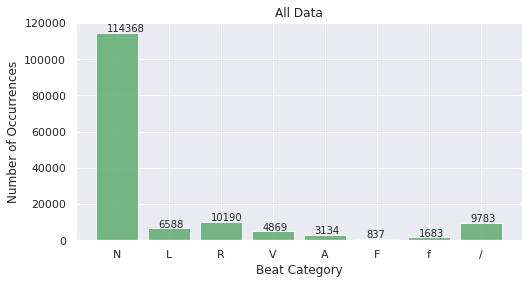

In [10]:
plot_counts(pd.DataFrame(all_data),'All Data','g')

# Plot Beats Split

After resampling, all the 8 classes in the train dataset have 3989 samples for the beat holdout method


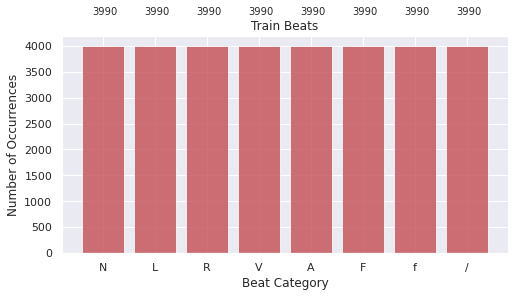

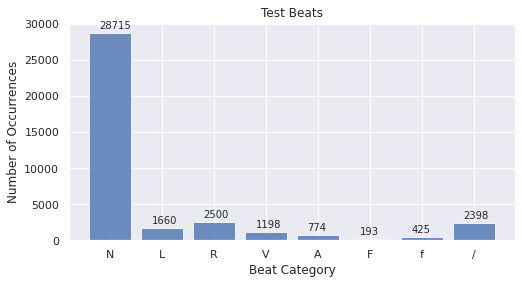

In [11]:
plot_counts(pd.DataFrame(train_beats),'Train Beats','r')
plot_counts(pd.DataFrame(test_beats),'Test Beats','b')

# Plot Patients Split

 After resampling, all the 8 classes in the train dataset 25789 samples for patient holdout method.

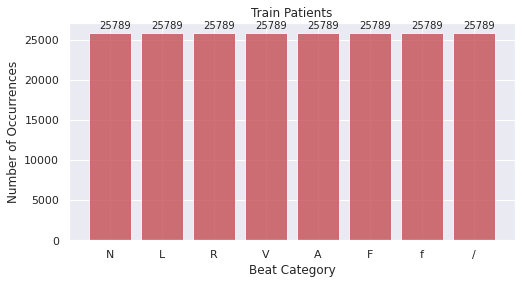

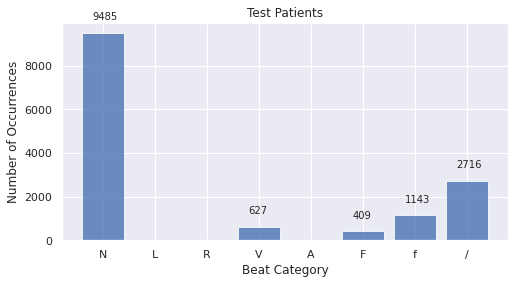

In [12]:
plot_counts(pd.DataFrame(train_patients),'Train Patients','r')
plot_counts(pd.DataFrame(test_patients),'Test Patients','b')